In [1]:
!pip install datasets diffusers



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00


In [2]:
!pip install datasets diffusers

In [3]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from torch.optim import Adam
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel  # Adjust based on actual model
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

In [4]:
# تحميل مجموعة بيانات الصور من Hugging Face
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:

image_size = 64

# Define data preprocessing and transformation operations
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally for increased diversity
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

In [6]:

# تعريف دالة لتحويل الصور ضمن مجموعة البيانات باستخدام العمليات المعرفة
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


In [7]:
# تطبيق التحويل على مجموعة البيانات
dataset.set_transform(transform)

In [8]:
# إنشاء مُحمل بيانات لتحميل البيانات على دفعات
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [9]:

# تحميل دفعة واحدة من البيانات للتحقق
batch = next(iter(train_dataloader))
print('Shape:', batch['images'].shape, '\nBounds:', batch['images'].min().item(), 'to', batch['images'].max().item())


Shape: torch.Size([32, 3, 64, 64]) 
Bounds: -1.0 to 1.0


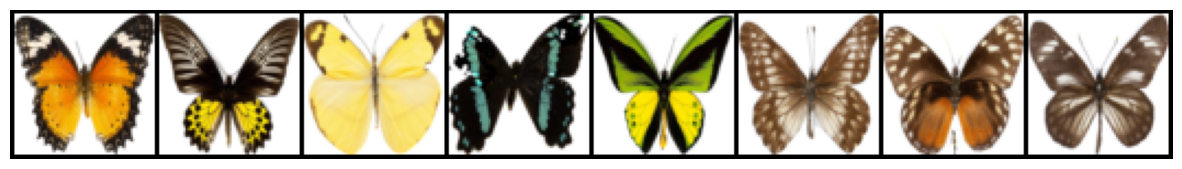

In [10]:

# عرض الصور
def show_images(images):
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_images(batch['images'][:8] * 0.5 + 0.5) # عرض الصور بعد إعادة تطبيعها إلى القيم بين 0 و 1

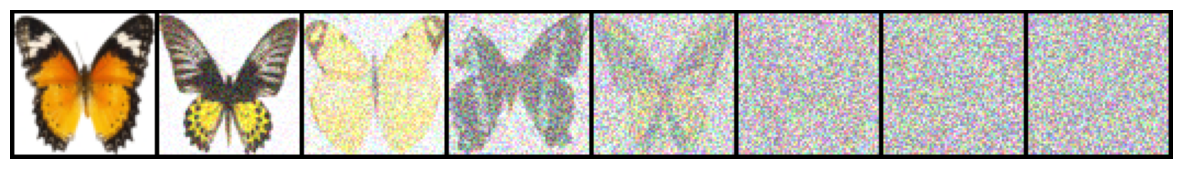

In [11]:


# إنشاء مُجدول DDPMScheduler مع 1000 خطوة تدريب وقيم بيتا مبدئية ونهائية
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02)

# تعريف مجموعة من الخطوات الزمنية
timesteps = torch.linspace(0, 999, 8).long()

# أخذ مجموعة من الصور من الدفعة وتحضير ضوضاء عشوائية بنفس الشكل
x = batch['images'][:8]
noise = torch.rand_like(x)

# إضافة الضوضاء إلى الصور
noised_x = scheduler.add_noise(x, noise, timesteps)

# عرض الصور المشوشة
show_images((noised_x * 0.5 + 0.5).clip(0, 1))


In [12]:

# إنشاء نموذج UNet2DModel
model = UNet2DModel(
    in_channels=3, # عدد القنوات المدخلة (3 قنوات لصورة RGB)
    sample_size=64, # حجم العينات المدخلة
    block_out_channels=(64, 128, 256, 512), # عدد القنوات في كل طبقة
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"), # أنواع طبقات النزول
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D") # أنواع طبقات الصعود
)

# تمرير دفعة من البيانات عبر النموذج
with torch.no_grad():
    out = model(noised_x, timestep=timesteps).sample

# التأكد من أن المخرجات لها نفس شكل المدخلات
print(out.shape) # يجب أن تكون torch.Size([8, 3, 64, 64])


torch.Size([8, 3, 64, 64])


In [13]:
torch.cuda.empty_cache()

In [14]:

# إعدادات التدريب
num_epochs = 50 # عدد العصور
lr = 1e-4 # معدل التعلم
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # تحديد الجهاز
model = model.to(device) # نقل النموذج إلى الجهاز
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # مُحسن AdamW
losses = [] # لتخزين قيم الخسارة لعرضها لاحقًا

In [15]:

# تدريب النموذج
for epoch in range(num_epochs):
    epoch_loss = 0
    for step, batch in enumerate(train_dataloader):
        # تحميل الصور الأصلية
        clean_images = batch["images"].to(device)

        # توليد ضوضاء عشوائية بنفس شكل الصور الأصلية
        noise = torch.randn(clean_images.shape).to(clean_images.device)

        # اختيار خطوات زمنية عشوائية لكل صورة
        timesteps = torch.randint(
            0,
            scheduler.num_train_timesteps,
            (clean_images.shape[0],),
            device=clean_images.device,
        ).long()

        # إضافة الضوضاء إلى الصور الأصلية حسب الخطوة الزمنية
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # الحصول على توقع النموذج للضوضاء
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # حساب الخسارة (الخطأ التربيعي بين التوقع والضوضاء الفعلية)
        loss = F.mse_loss(noise_pred, noise)

        # تخزين قيمة الخسارة لعرضها لاحقًا
        losses.append(loss.item())

        # تحديث أوزان النموذج بناءً على الخسارة
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # جمع الخسارة لكل خطوة في العصر
        epoch_loss += loss.item()

    # حساب الدقة كمتوسط الخسارة لكل خطوة في العصر
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch [1/50], Loss: 0.4288
Epoch [2/50], Loss: 0.1204
Epoch [3/50], Loss: 0.0868
Epoch [4/50], Loss: 0.0721
Epoch [5/50], Loss: 0.0619
Epoch [6/50], Loss: 0.0573
Epoch [7/50], Loss: 0.0474
Epoch [8/50], Loss: 0.0440
Epoch [9/50], Loss: 0.0384
Epoch [10/50], Loss: 0.0374
Epoch [11/50], Loss: 0.0347
Epoch [12/50], Loss: 0.0326
Epoch [13/50], Loss: 0.0364
Epoch [14/50], Loss: 0.0310
Epoch [15/50], Loss: 0.0308
Epoch [16/50], Loss: 0.0267
Epoch [17/50], Loss: 0.0270
Epoch [18/50], Loss: 0.0250
Epoch [19/50], Loss: 0.0247
Epoch [20/50], Loss: 0.0242
Epoch [21/50], Loss: 0.0249
Epoch [22/50], Loss: 0.0242
Epoch [23/50], Loss: 0.0242
Epoch [24/50], Loss: 0.0224
Epoch [25/50], Loss: 0.0209
Epoch [26/50], Loss: 0.0224
Epoch [27/50], Loss: 0.0234
Epoch [28/50], Loss: 0.0209
Epoch [29/50], Loss: 0.0234
Epoch [30/50], Loss: 0.0219
Epoch [31/50], Loss: 0.0216
Epoch [32/50], Loss: 0.0201
Epoch [33/50], Loss: 0.0190
Epoch [34/50], Loss: 0.0202
Epoch [35/50], Loss: 0.0190
Epoch [36/50], Loss: 0.0206
E

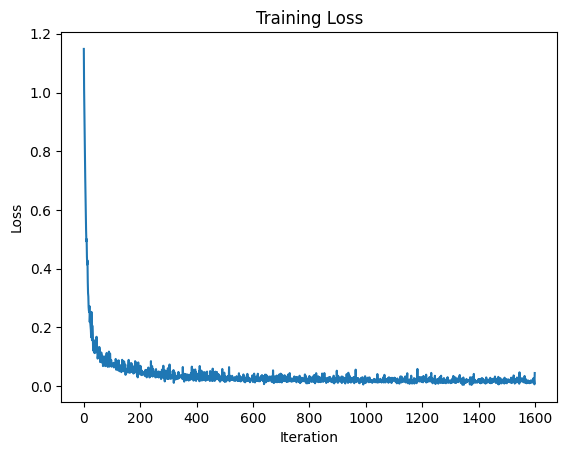

In [16]:

# عرض منحنى الخسارة بعد التدريب
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()



In [26]:

# Create DDPMPipeline
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)

# Generate new images using the trained model
generated_images = pipeline(batch_size=4).images

  0%|          | 0/1000 [00:00<?, ?it/s]

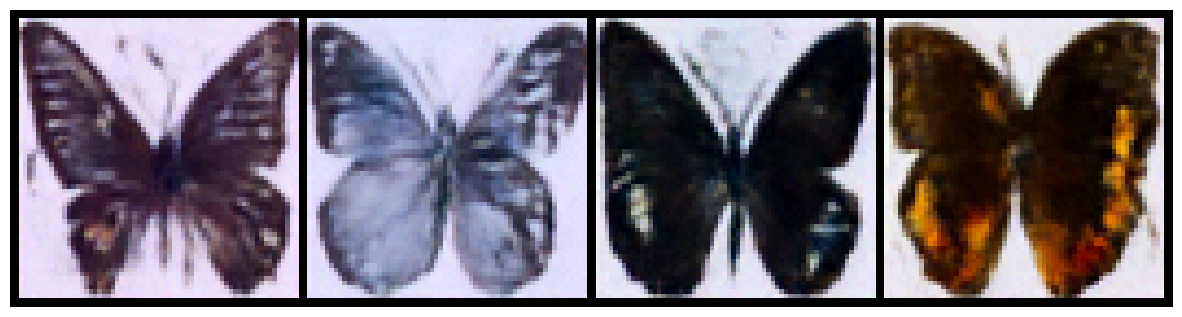

In [27]:
tensor_images = [ToTensor()(img) for img in generated_images]

# عرض الصور المولدة
show_images(tensor_images)